   #   Schritt	Thema	Status 
# 1	X Datenimport mit dtype=str & low_memory=False	
# 2	X Strukturprüfung (shape, columns, info)	
# 3	X Fehlende Werte analysiert & prozentual dargestellt	
# 4	X Zielgerichtete Imputation mit Labels	
# 5	X ObservationDate robust mit errors='coerce' umgewandelt	
# 6	X Koordinaten in float gewandelt & validiert	
# 7	X Tiefe bereinigt (-999.0, NaNs), Deskriptivstatistik	
# 8	X Unnötige Spalten entfernt	
# 9	X Textbereinigung für alle object-Spalten	
# 10 X	(Optional ausgelassen – nicht kritisch)	✘
# 11 X	Zeilen mit zu vielen NaNs entfernt (thresh=10)	
# 12 X	Zeitspalten (Year, Month, Decade) generiert	
# 13 X	Binning der Tiefe in sinnvolle Zonen	
# 14 X	Artendiversität berechnet (nunique, top10)	
# 15 X	Geografische Verteilung analysiert (Localities, Ranges)	
# 16–19 X	Alle relevanten Visuals erzeugt & beschriftet	
# 20 X	Interaktive Karte via folium mit Cluster	

In [1]:
#  SCHRITT 1: Daten einlesen
import pandas as pd

# Datei einlesen
# - low_memory=False: verhindert Typ-Verwirrung bei großen Dateien
# - dtype=str: liest alles als String ein (für saubere nachträgliche Umwandlungen)
df = pd.read_csv("deep_sea_corals.csv", low_memory=False, dtype=str)


In [2]:
#  SCHRITT 2: Grundstruktur prüfen

# 2.1 Form (Zeilen, Spalten)
df_shape = df.shape  # z. B. (513373, 20)

# 2.2 Spalteninfo & Nicht-Null-Zählung
df_info = df.info()

# 2.3 Spaltennamen als Liste
df_columns = df.columns.tolist()

# Ausgabe zur Kontrolle
print(df_columns)
print(df_shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513373 entries, 0 to 513372
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CatalogNumber            513372 non-null  object
 1   DataProvider             513372 non-null  object
 2   ScientificName           513372 non-null  object
 3   VernacularNameCategory   513197 non-null  object
 4   TaxonRank                513364 non-null  object
 5   Station                  253590 non-null  object
 6   ObservationDate          513367 non-null  object
 7   latitude                 513373 non-null  object
 8   longitude                513373 non-null  object
 9   DepthInMeters            513372 non-null  object
 10  DepthMethod              496845 non-null  object
 11  Locality                 389645 non-null  object
 12  LocationAccuracy         484662 non-null  object
 13  SurveyID                 306228 non-null  object
 14  Repository          

In [3]:
#  SCHRITT 3: Fehlende Werte analysieren

# 3.1 Anzahl fehlender Werte pro Spalte
missing_counts = df.isnull().sum()

# 3.2 Prozentualer Anteil fehlender Werte pro Spalte
missing_percent = (missing_counts / len(df)) * 100

# 3.3 Zusammenführen zu Übersichtstabelle
missing_df = pd.DataFrame({
    'Fehlende Werte': missing_counts,
    'Prozent (%)': missing_percent
}).sort_values(by='Fehlende Werte', ascending=False)

# 3.4 Anzeige der fehlenden Werte
print(missing_df)


                         Fehlende Werte  Prozent (%)
Station                          259783    50.603168
SurveyID                         207145    40.349804
Locality                         123728    24.100995
SampleID                         111079    21.637094
EventID                           41232     8.031587
LocationAccuracy                  28711     5.592620
SamplingEquipment                 27490     5.354781
IdentificationQualifier           24782     4.827289
Repository                        16789     3.270332
DepthMethod                       16528     3.219491
RecordType                        12296     2.395140
VernacularNameCategory              176     0.034283
TaxonRank                             9     0.001753
ObservationDate                       6     0.001169
CatalogNumber                         1     0.000195
DataProvider                          1     0.000195
ScientificName                        1     0.000195
DepthInMeters                         1     0.

In [4]:
#  SCHRITT 4: Fehlende Werte gezielt bereinigen

# 4.1 'Station': viele NaNs → als "Unknown Station" bezeichnen
df['Station'] = df['Station'].fillna("Unknown Station")

# 4.2 'SurveyID': Quelle wichtig, aber oft fehlend → als "Unknown Survey"
df['SurveyID'] = df['SurveyID'].fillna("Unknown Survey")

# 4.3 'Locality': für Karte wichtig → "Unspecified"
df['Locality'] = df['Locality'].fillna("Unspecified")

# 4.4 'SampleID': stark individuell → "No Sample ID"
df['SampleID'] = df['SampleID'].fillna("No Sample ID")

# 4.5 'EventID': wichtig für Gruppierung → "No Event"
df['EventID'] = df['EventID'].fillna("No Event")


In [5]:
#  SCHRITT 5: Datumsformat bereinigen

# 'ObservationDate' in echtes Datum umwandeln
# Fehlerhafte Formate werden als NaT behandelt
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], errors='coerce')

# Kontrolle: Anzahl fehlgeschlagener Umwandlungen
print("Ungültige Datumseinträge:", df['ObservationDate'].isna().sum())


Ungültige Datumseinträge: 15796


In [6]:
#  SCHRITT 6: Koordinaten in float umwandeln

# Umwandlung in numerische Werte (Float); Fehlerhafte → NaN
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Kontrolle: Anzahl fehlerhafter Koordinaten
print("Unkonvertierbare latitude:", df['latitude'].isna().sum())
print("Unkonvertierbare longitude:", df['longitude'].isna().sum())


Unkonvertierbare latitude: 1
Unkonvertierbare longitude: 1


In [7]:
#  SCHRITT 7: Tiefenwerte bereinigen & analysieren

# 7.1 Tiefenwerte zuerst in float konvertieren (falls noch nicht erfolgt)
df['DepthInMeters'] = pd.to_numeric(df['DepthInMeters'], errors='coerce')

# 7.2 Fehlerwert -999.0 als NA markieren
df['DepthInMeters'] = df['DepthInMeters'].replace(-999.0, pd.NA)

# 7.3 Statistische Übersicht nach Bereinigung
depth_description = df['DepthInMeters'].describe()
print("Tiefenstatistik:\n", depth_description)

# 7.4 Anzahl der fehlenden Tiefenwerte anzeigen
missing_depth = df['DepthInMeters'].isna().sum()
print("Fehlende Werte in DepthInMeters:", missing_depth)


Tiefenstatistik:
 count     509375.0
unique      4073.0
top          113.0
freq        5312.0
Name: DepthInMeters, dtype: float64
Fehlende Werte in DepthInMeters: 3998


In [8]:
# SCHRITT 8: Optionale Spalten entfernen, die zu individuell oder redundant sind
drop_columns = ['SampleID', 'CatalogNumber']

# Nur entfernen, wenn sie für Analyse nicht mehr benötigt werden
df.drop(columns=drop_columns, inplace=True)

# Kontrolle: verbleibende Spalten
print(df.columns.tolist())


['DataProvider', 'ScientificName', 'VernacularNameCategory', 'TaxonRank', 'Station', 'ObservationDate', 'latitude', 'longitude', 'DepthInMeters', 'DepthMethod', 'Locality', 'LocationAccuracy', 'SurveyID', 'Repository', 'IdentificationQualifier', 'EventID', 'SamplingEquipment', 'RecordType']


In [9]:
# SCHRITT 9: Alle Textspalten bereinigen (Whitespace entfernen)

# Nur object-Spalten auswählen
text_columns = df.select_dtypes(include='object').columns

# Whitespace entfernen – nur auf echte Strings anwendbar
for col in text_columns:
    df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)


In [10]:
# SCHRITT 11: Zeilen mit zu vielen fehlenden Werten entfernen

# Behalte nur Zeilen, die mindestens 10 gültige Werte enthalten
df.dropna(thresh=10, inplace=True)

# Kontrolle: Form nach Filterung
print("Neue Datenform:", df.shape)


Neue Datenform: (513372, 18)


In [11]:
# SCHRITT 12: Zeitspalten aus 'ObservationDate' ableiten

# Jahres-, Monats- und Dekadenspalte erzeugen
df['Year'] = df['ObservationDate'].dt.year
df['Month'] = df['ObservationDate'].dt.month
df['Decade'] = (df['Year'] // 10) * 10  # Beispiel: 2014 → 2010

# Kontrolle: Vorschau der Zeitspalten
print(df[['ObservationDate', 'Year', 'Month', 'Decade']].head())


  ObservationDate    Year  Month  Decade
1      2015-09-02  2015.0    9.0  2010.0
2      2015-09-01  2015.0    9.0  2010.0
3      2015-09-01  2015.0    9.0  2010.0
4      2015-09-01  2015.0    9.0  2010.0
5      2015-09-01  2015.0    9.0  2010.0


In [ ]:
# SCHRITT 13: Tiefenzonen einteilen (Binning)

# 13.0: Sicherstellen, dass 'DepthInMeters' float ist
df['DepthInMeters'] = pd.to_numeric(df['DepthInMeters'], errors='coerce')

# 13.1: Tiefenklassen definieren (bins & Labels)
bins = [0, 100, 500, 1000, 3000, 6000, 11000]
labels = ['0–100 m', '100–500 m', '500–1000 m', '1000–3000 m', '3000–6000 m', '6000–11000 m']

# 13.2: Kategorien zuweisen
df['DepthZone'] = pd.cut(df['DepthInMeters'], bins=bins, labels=labels, right=False)

#  ZWISCHENSCHRITT (empfohlen): Auch NaNs anzeigen lassen
depth_zone_counts = df['DepthZone'].value_counts(dropna=False).sort_index()
print(depth_zone_counts)

# 13.3: Kontrolle
print(df[['DepthInMeters', 'DepthZone']].head())


DepthZone
0–100 m          48727
100–500 m       187084
500–1000 m      129712
1000–3000 m     129675
3000–6000 m      14172
6000–11000 m         5
NaN               3997
Name: count, dtype: int64
   DepthInMeters   DepthZone
1          959.0  500–1000 m
2          953.0  500–1000 m
3          955.0  500–1000 m
4          955.0  500–1000 m
5          968.0  500–1000 m


In [13]:
# SCHRITT 14: Artendiversität analysieren

# 14.1: Anzahl eindeutiger Arten
unique_species_count = df['ScientificName'].nunique()

# 14.2: Häufigste Arten anzeigen
top_species = df['ScientificName'].value_counts().head(10)

# Ausgabe
print("Anzahl einzigartiger Arten:", unique_species_count)
print("Top 10 Arten:")
print(top_species)


Anzahl einzigartiger Arten: 2888
Top 10 Arten:
ScientificName
Porifera                 77066
Heteropolypus ritteri    21447
Lophelia pertusa         20304
Pennatulacea             17672
Stylaster sp.            14595
Hexactinellida           10438
Gorgonacea                9856
Paragorgia sp.            9416
Farrea occa               7979
Funiculina sp.            7389
Name: count, dtype: int64


In [14]:
# SCHRITT 15: Geografische Verteilung nach Bereinigung

# 15.0: Koordinaten erneut absichern (falls z. B. durch merge verändert)
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# 15.1: Häufigste Fundorte
top_locations = df['Locality'].value_counts().head(10)

# 15.2: Koordinatenbereich analysieren
lat_range = (df['latitude'].min(), df['latitude'].max())
lon_range = (df['longitude'].min(), df['longitude'].max())

# Ausgabe
print("Top-Fundorte:")
print(top_locations)
print("Breitengrad-Bereich:", lat_range)
print("Längengrad-Bereich:", lon_range)


Top-Fundorte:
Locality
Unspecified                                                                         123727
Davidson Seamount                                                                    40114
Pioneer Seamount                                                                     23971
OLYMPIC COAST                                                                        22478
Rodriguez Seamount                                                                   18702
Olympic Coast National Marine Sanctuary                                              14042
Alaska; Aleutian Islands                                                             12021
Southern California Bight; Channel Islands National Marine Sanctuary; Piggy_Bank     11587
Viosca Knoll                                                                          9982
Shutter ridge                                                                         8351
Name: count, dtype: int64
Breitengrad-Bereich: (np.float64(-78.9167

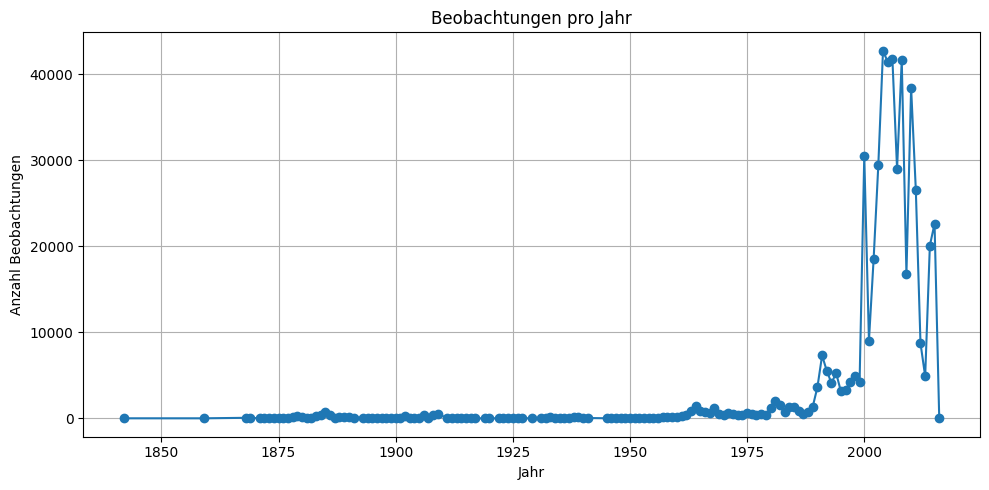

In [15]:
# SCHRITT 16: Anzahl der Beobachtungen pro Jahr darstellen

import matplotlib.pyplot as plt

# Gruppierung und Zählung
yearly_counts = df['Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Beobachtungen pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Beobachtungen")
plt.grid(True)
plt.tight_layout()
plt.show()


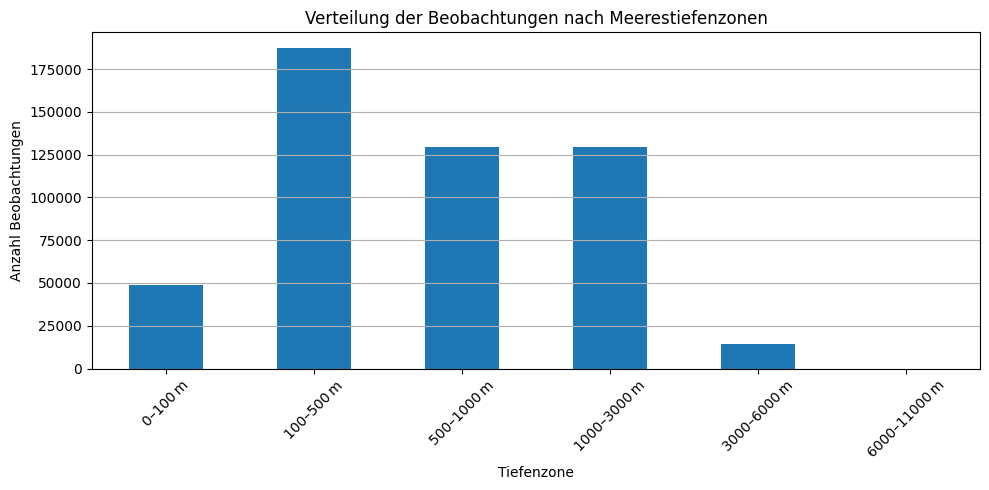

In [16]:
# SCHRITT 17: Visualisierung der Tiefenzonen (Depth Binning)

import matplotlib.pyplot as plt

# Zähle Vorkommen pro Zone
depth_zone_counts = df['DepthZone'].value_counts().sort_index()

# Balkendiagramm
plt.figure(figsize=(10, 5))
depth_zone_counts.plot(kind='bar')
plt.title("Verteilung der Beobachtungen nach Meerestiefenzonen")
plt.xlabel("Tiefenzone")
plt.ylabel("Anzahl Beobachtungen")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


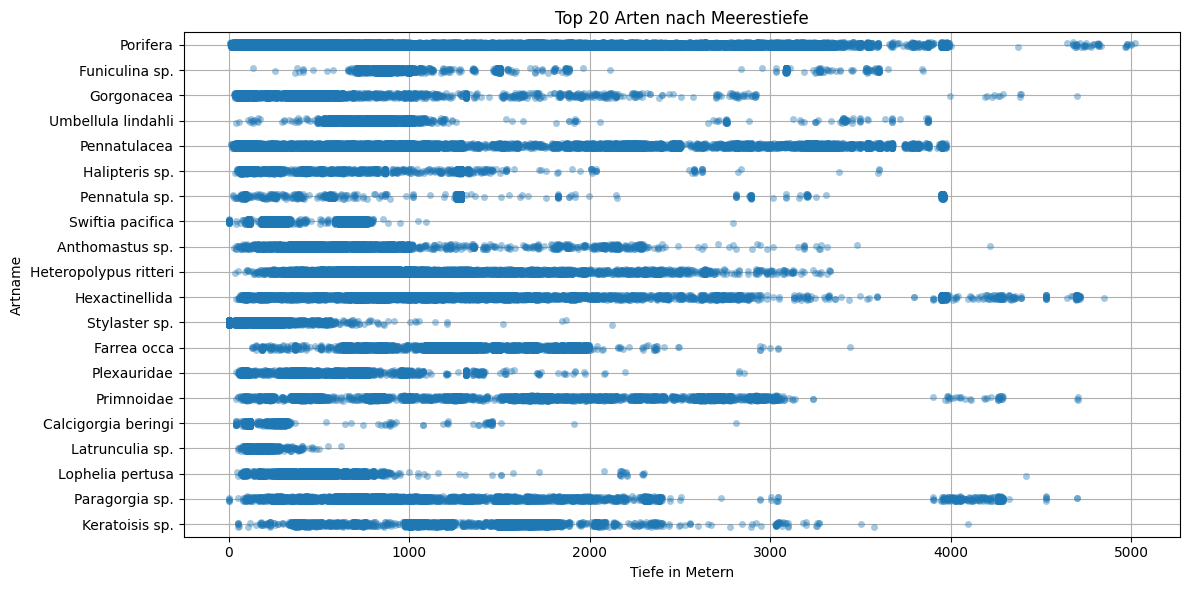

In [17]:
# SCHRITT 18 FIX: Nur die 20 häufigsten Arten visualisieren nach Tiefe

import seaborn as sns
import matplotlib.pyplot as plt

# Top 20 Arten nach Anzahl
top_20 = df['ScientificName'].value_counts().head(20).index

# Gefiltertes DataFrame
df_top = df[df['ScientificName'].isin(top_20)]

# Scatterplot: Tiefe vs Art
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_top, x='DepthInMeters', y='ScientificName', alpha=0.4, jitter=True)

plt.title("Top 20 Arten nach Meerestiefe")
plt.xlabel("Tiefe in Metern")
plt.ylabel("Artname")
plt.grid(True)
plt.tight_layout()
plt.show()


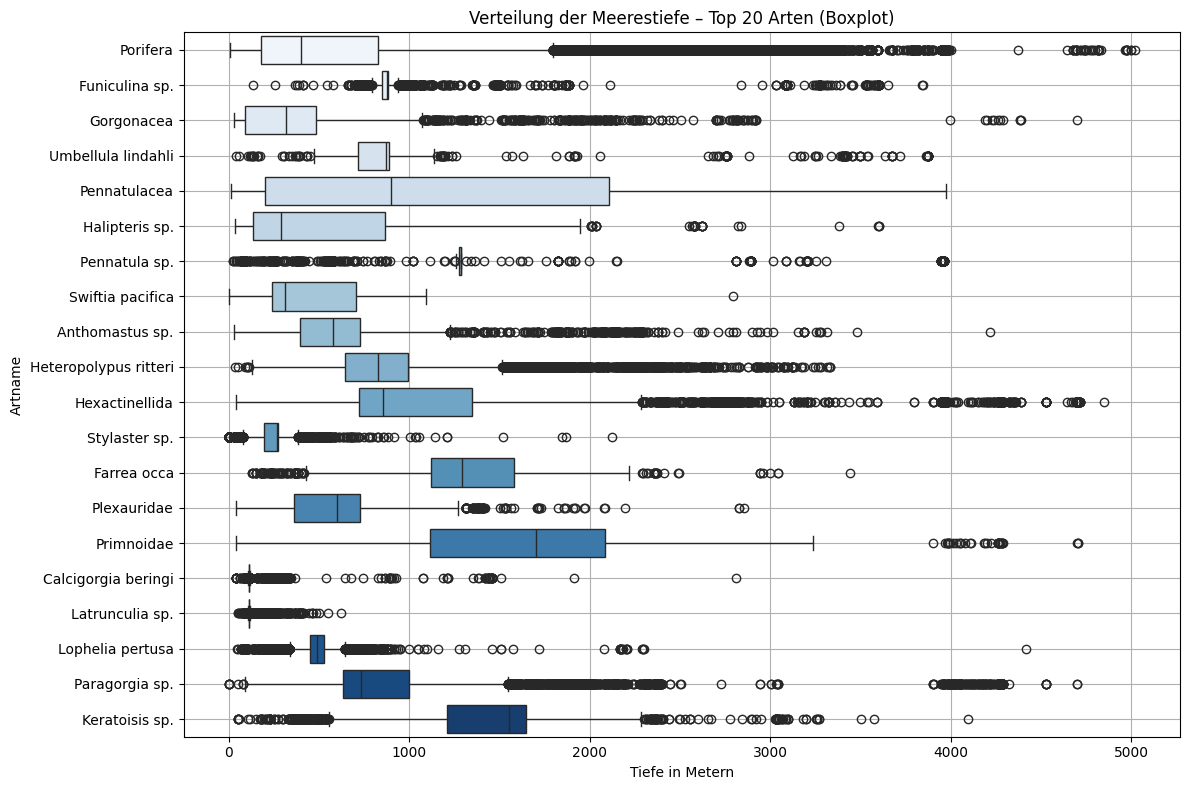

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df[df['ScientificName'].isin(top_20)],
    y='ScientificName',
    x='DepthInMeters',
    hue='ScientificName',          # nötig für Palette
    palette='Blues',
    dodge=False,                   # verhindert doppelte Boxen
    legend=False                   # blendet redundante Legende aus
)

plt.title("Verteilung der Meerestiefe – Top 20 Arten (Boxplot)")
plt.xlabel("Tiefe in Metern")
plt.ylabel("Artname")
plt.grid(True)
plt.tight_layout()
plt.show()


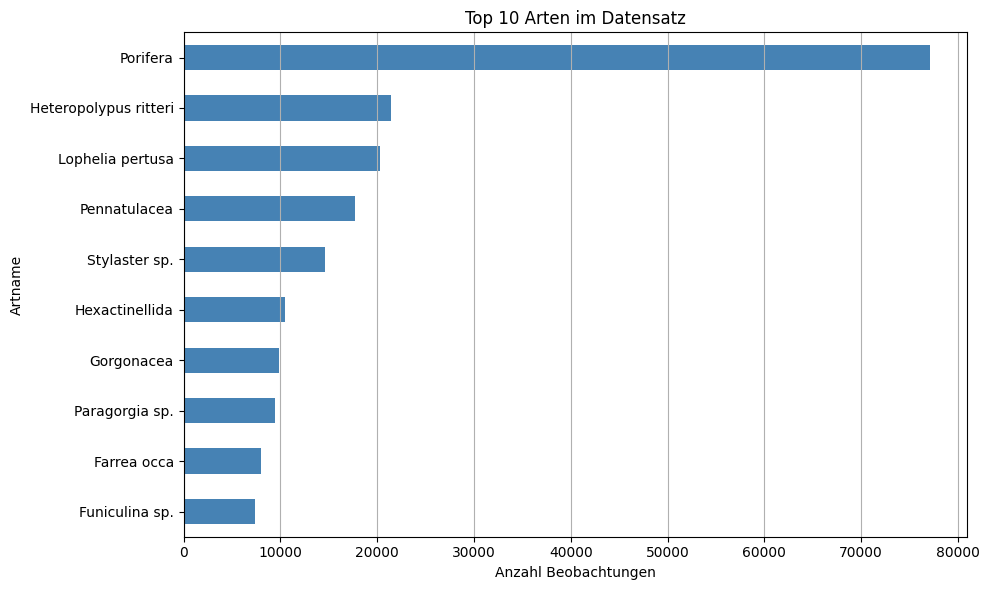

In [19]:
# SCHRITT 19: Die 10 häufigsten Arten als Balkendiagramm

import matplotlib.pyplot as plt

# Zähle die 10 häufigsten Arten
top_10_species = df['ScientificName'].value_counts().head(10)

# Visualisierung
plt.figure(figsize=(10, 6))
top_10_species.plot(kind='barh', color='steelblue')
plt.title("Top 10 Arten im Datensatz")
plt.xlabel("Anzahl Beobachtungen")
plt.ylabel("Artname")
plt.gca().invert_yaxis()  # Häufigste oben
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [20]:
# SCHRITT 20: Interaktive Karte mit folium

import folium
from folium.plugins import MarkerCluster

# Stichprobe (1000 Punkte)
sample_df = df[['latitude', 'longitude', 'ScientificName']].dropna().sample(n=1000, random_state=42)

# Basiskarte zentriert (Mittelpunkt der Weltmeere)
m = folium.Map(location=[0, 0], zoom_start=2)

# Cluster hinzufügen
marker_cluster = MarkerCluster().add_to(m)

# Marker einfügen
for _, row in sample_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['ScientificName']
    ).add_to(marker_cluster)

# Karte anzeigen
m


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
from folium.plugins import MarkerCluster
from pptx import Presentation
from pptx.util import Inches
import webbrowser

# Basisverzeichnis
base_path = r"C:\Users\denni\OneDrive\Desktop\Abschlußprojekt"

# Zeitspalten vorbereiten
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], errors='coerce')
df['Year'] = df['ObservationDate'].dt.year
df['Month'] = df['ObservationDate'].dt.month
df['Decade'] = (df['Year'] // 10) * 10

# Plot-Stil
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 5)

# 1. Beobachtungen pro Jahr
yearly_counts = df['Year'].value_counts().sort_index()
plt.figure()
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Beobachtungen pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Beobachtungen")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_path, "01_beobachtungen_pro_jahr.png"))
plt.close()

# 2. Tiefenzonen-Verteilung
depth_zone_counts = df['DepthZone'].value_counts().sort_index()
plt.figure()
depth_zone_counts.plot(kind='bar')
plt.title("Verteilung der Beobachtungen nach Tiefenzonen")
plt.xlabel("Tiefenzone")
plt.ylabel("Anzahl Beobachtungen")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(base_path, "02_tiefenzonen.png"))
plt.close()

# 3. Top 10 Arten
top_10_species = df['ScientificName'].value_counts().head(10)
plt.figure()
top_10_species.plot(kind='barh', color='steelblue')
plt.title("Top 10 Arten im Datensatz")
plt.xlabel("Anzahl Beobachtungen")
plt.ylabel("Artname")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.savefig(os.path.join(base_path, "03_top_10_arten.png"))
plt.close()

# 4. Scatterplot – Top 20 Arten nach Tiefe
top_20 = df['ScientificName'].value_counts().head(20).index
df_top = df[df['ScientificName'].isin(top_20)]

plt.figure(figsize=(12, 6))
sns.stripplot(data=df_top, x='DepthInMeters', y='ScientificName', alpha=0.4, jitter=True)
plt.title("Top 20 Arten nach Meerestiefe (Scatterplot)")
plt.xlabel("Tiefe in Metern")
plt.ylabel("Artname")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_path, "04_top20_scatter.png"))
plt.close()

# 5. Boxplot – Top 20 Arten nach Tiefe
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_top,
    y='ScientificName',
    x='DepthInMeters',
    hue='ScientificName',
    palette='Blues',
    dodge=False,
    legend=False
)
plt.title("Verteilung der Meerestiefe – Top 20 Arten (Boxplot)")
plt.xlabel("Tiefe in Metern")
plt.ylabel("Artname")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_path, "05_top20_boxplot.png"))
plt.close()

# 6. Globale Karte als HTML erstellen und öffnen
map_html_path = os.path.join(base_path, "deep_sea_map.html")

sample_df = df[['latitude', 'longitude', 'ScientificName']].dropna().sample(n=1000, random_state=42)
m = folium.Map(location=[0, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(m)

for _, row in sample_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['ScientificName']
    ).add_to(marker_cluster)

m.save(map_html_path)
webbrowser.open("file:///" + map_html_path)

# Bildpfade (ohne Karte, da manuell)
bilder = {
    "jahr": os.path.join(base_path, "01_beobachtungen_pro_jahr.png"),
    "tiefe": os.path.join(base_path, "02_tiefenzonen.png"),
    "arten": os.path.join(base_path, "03_top_10_arten.png"),
    "scatter": os.path.join(base_path, "04_top20_scatter.png"),
    "box": os.path.join(base_path, "05_top20_boxplot.png")
}

# PowerPoint Präsentation erstellen
prs = Presentation()

# Titelfolie
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Deep Sea Biodiversity Analysis"
slide.placeholders[1].text = "Abschlussprojekt – Dennis Maier | DataSmart Point 2025"

# Agenda
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Agenda"
slide.placeholders[1].text = "- Einleitung\n- Ziel & Datenquelle\n- Explorative Analyse\n- Erkenntnisse & Visuals\n- Globale Karte\n- Fazit"

# Einleitung
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Einleitung"
slide.placeholders[1].text = (
    "Die Tiefsee ist eines der geheimnisvollsten Ökosysteme unseres Planeten.\n"
    "Dieses Projekt beleuchtet die biologische Vielfalt basierend auf über 500.000 Beobachtungen "
    "aus der NOAA Deep Sea Coral Database."
)

# Ziel & Datenquelle
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Ziel & Datenquelle"
slide.placeholders[1].text = (
    "Ziel: Erkennen ökologischer Tiefenzonen & dominanter Arten\n"
    "Quelle: NOAA Deep Sea Coral & Sponge Database\n"
    "Tools: Python, Pandas, Seaborn, Matplotlib, PowerPoint"
)

# Visuals einfügen
def add_visual_slide(title, img_path):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = title
    slide.shapes.add_picture(img_path, Inches(0.8), Inches(1.2), width=Inches(8.2))

add_visual_slide("Beobachtungen pro Jahr", bilder["jahr"])
add_visual_slide("Verteilung nach Meerestiefen", bilder["tiefe"])
add_visual_slide("Top 10 Arten im Datensatz", bilder["arten"])
add_visual_slide("Top 20 Arten nach Tiefe (Scatter)", bilder["scatter"])
add_visual_slide("Top 20 Arten nach Tiefe (Boxplot)", bilder["box"])

# Leere Folie für manuelle Karteneinfügung
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Globale Karte – bitte manuell einfügen"

# Interpretation
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Globale Verteilung – Interpretation"
slide.placeholders[1].text = (
    "Hier siehst du die manuell eingefügte Karte mit 1.000 zufällig gewählten Beobachtungspunkten weltweit.\n\n"
    "Hotspots liegen entlang von Kontinentalhängen und Seamounts.\n"
    "Besonders aktiv: Pazifik, Nordatlantik, Südwestpazifik."
)

# Fazit
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Fazit & Ausblick"
slide.placeholders[1].text = (
    "- Biodiversität konzentriert sich in mittleren Tiefen (100–1000m)\n"
    "- Porifera, Lophelia pertusa & andere als Tiefsee-Marker\n"
    "- Schutz & Monitoring sind entscheidend\n"
    "\nAusblick: KI-Klassifikation, Klimabezug, Schutzkonzepte"
)

# Abschluss
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Danke für Ihre Aufmerksamkeit"
slide.placeholders[1].text = "Dennis Maier | Abschlussprojekt 2025 – Fragen willkommen"

# Speichern
output_file = os.path.join(base_path, "DeepSea_Praesentation_DennisMaier_FINAL.pptx")
prs.save(output_file)
print(f"\nPräsentation erfolgreich gespeichert unter:\n{output_file}")



Präsentation erfolgreich gespeichert unter:
C:\Users\denni\OneDrive\Desktop\Abschlußprojekt\DeepSea_Praesentation_DennisMaier_FINAL.pptx
